In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def tumor_cell_population_function(T,E,M):
    """
    Creates a differential equation to model a tumor cell population over time
    
    Parameters: 
    ----------
    r : float
        rate of tumor growth
    T : float
        number of tumor cells for time t
    b : float
        capacity of the tumor cell
    a : float
        paramter of cancer cleanup
    E : float
        number of effector cells at time t
    g : float
        half-saturation for cancer cleanup
    K_t : float
        rate of tumor cell death by chemotherapy drug
    M : float
        concentration of chemotherapy drug at time t
    Returns: 
    -------
    float
        change in tumor cells after one timestep
    """
    r = 4.31 * 10**(-3)
    b = 10**(-9)
    a = 3.41 * 10**(-10)
    g = 10**5
    K_t = 1 # not sure what this is yet
    dT = r*T*(1-(b*T))-a*((E*T)/(T+g))-(K_t*M*T)
    return dT

In [9]:
def z_M(M):
    return 1 - np.exp(-M)

def tumor_immune_chemo_forward_integrate(initial_conditions, params, t):
    """
    Forward integrates the tumor, dendritic, NK T, CD8+ T cell, chemotherapy model
    
    Parameters: 
    ----------
    initial_conditions : (int, int, int, int, int, int)
        Tuple of initial conditions for the IVP
    params : floats
        parameters of the model
    t : [ints]
        an array of timepoints, ASSUMED TO BE EQUALLY SPACED. 
    Returns: 
    -------
    np.array, np.array, np.array
        Returns a numpy array of T, N, D, and M arrays.
    """
    T0, N0, D0, L0, M0, I0 = initial_conditions
    T, N, D, L, M, I = [T0], [N0], [D0], [L0], [M0], [I0]
    a, b, c1, j, k, K_T, s1, g1, h1, c2, d1, K_N, e, s2, f1, d2, d3, K_D, g, f2, h, u, r1, p_I, g_I, i, v_L, d4, V_m, d5, V_i, K_L = params
    dt = t[1] - t[0]

    for _ in t[1:]:
        Tt = T[-1] + (a*T[-1]*(1 - b*T[-1]) - (c1*N[-1] + j*D[-1] + k*L[-1])*T[-1] - K_T*z_M(M[-1])*T[-1])*dt
        Nt = N[-1] + (s1+((g1 * N[-1]*T[-1]**2) / (h1 + T[-1]**2))-((c2*T[-1] - d1*D[-1])*N[-1]) - K_N*z_M(M[-1])*N[-1] - e*N[-1])*dt
        Dt = D[-1] + (s2 - (f1*L[-1] + d2*N[-1] - d3*T[-1])*D[-1] - K_D*z_M(M[-1])*D[-1] - g*D[-1])*dt
        Lt = L[-1] + (f2*D[-1]*T[-1] - h*L[-1]*T[-1] - u*N[-1]*(L[-1]**2) + r1*N[-1]*T[-1] + ((p_I * L[-1]*I[-1]) / (g_I + I[-1])) - K_L*z_M(M[-1])*L[-1] - i*L[-1] + v_L)*dt
        Mt = M[-1] + (-d4*M[-1] + V_m)*dt
        It = I[-1] + (-d5*I[-1] + V_i)*dt
        
        T.append(Tt)
        N.append(Nt)
        D.append(Dt)
        L.append(Lt)
        M.append(Mt)
        I.append(It)
    return T, N, D, L, M, I

In [10]:
def chemo_forward_integrate(initial_conditions, params, t):
    """
    Forward integrates just the chemotherapy model
    
    Parameters: 
    ----------
    initial_conditions : (int, int, int)
        Tuple of initial conditions for the IVP
    params : floats
        parameters of the model
    t : [ints]
        an array of timepoints, ASSUMED TO BE EQUALLY SPACED. 
    Returns: 
    -------
    np.array, np.array, np.array
        Returns a numpy array of M arrays.
    """
    M0 = initial_conditions
    M = [M0]
    
    gamma, V_m = params
    dt = t[1] - t[0]
    
    for _ in t[1:]:
        Mt = M[-1] + (-gamma*M[-1] + V_m)*dt
        M.append(Mt)
    return M

Text(0, 0.5, 'Cell Population')

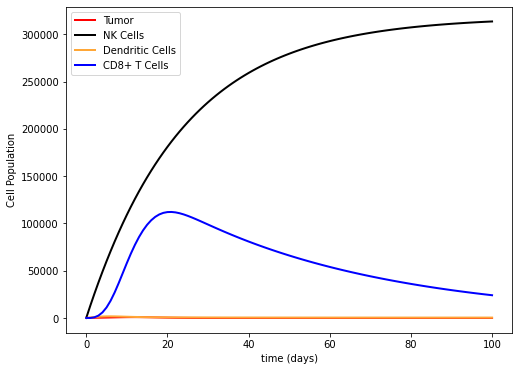

In [11]:
# First computation

T0 = 100
N0 = 1
D0 = 1
L0 = 1
M0 = 0.5
I0 = 0.5
initial_conditions = (T0, N0, D0, L0, M0, I0)

# a, b, c1, j, k, K_T, s1, g1, h1, c2, d1, K_N, e, s2, f1, d2, d3, K_D, g, f2, h, u, r1, p_I, g_I, i, v_L, d4, V_m, d5, V_i, K_L
a = 4.31e-1 # Tumor growth rate
b = 2.17e-8 # Tumor carrying capacity
c1 = 3.5e-6 # NK cell tumor cell kill rate
j = 1e-7 # dendritic cell tumor cell kill rate
k = 1e-7 # CD8+ T cell tumor cell kill rate
K_T = 0

s1 = 1.3e4 # source of NK cells
g1 = 0
h1 = 0
c2 = 1e-7 # NK cell inactivation rate
d1 = 1e-6 # rate of dendritic cell priming NK cells
K_N = 0
e = 4.12e-2 # death rate of NK cell

s2 = 4.8e2 # source of dendritic cell
f1 = 1e-8 # CD8+ T cell dendritic cells kill rate
d2 = 4e-6 # NK cell dendritic cell kill rate
d3 = 0 # rate of tumor cells priming dendritic cells, originally 1e-4
K_L = 0
g = 2.4e-2 # death rate of dendritic cells

f2 = 0.01 # rate of dendritic cells priming CD8+ T cell
h = 3.42e-10 # T inactivation rate by tumor cells
u = 0 # regulatory function by Nk cells of CD8+ T cells, originally 1.8e-8
r1 = 0
p_I = 0
g_I = 0
i = 2e-2 # death rate of CD8+ T cells
v_L = 0

d4 = 0
V_m = 0
d5 = 0
V_i = 0
K_D = 0

params = a, b, c1, j, k, K_T, s1, g1, h1, c2, d1, K_N, e, s2, f1, d2, d3, K_D, g, f2, h, u, r1, p_I, g_I, i, v_L, d4, V_m, d5, V_i, K_L

# Timesteps in days
t_max = 100
dt = 1
t = np.linspace(0, t_max, int(t_max/dt) + 1)

results = tumor_immune_chemo_forward_integrate(initial_conditions, params, t)

# Plot Results
colors = {
'T':'red',
'N':'black',
'D':'#FFA737',
'L': 'blue'
}

# Set up the axes
fig, ax = plt.subplots(figsize=(8,6), nrows=1,ncols=1)
T,N,D,L,M,I = results
plt.plot(t,T,label='Tumor',color=colors['T'],linewidth=2)
plt.plot(t,N,label='NK Cells',color=colors['N'],linewidth=2)
plt.plot(t,D,label='Dendritic Cells',color=colors['D'],linewidth=2)
plt.plot(t,L,label='CD8+ T Cells',color=colors['L'],linewidth=2)

# Make the plot attractive
ax.legend(loc='best')
ax.set_xlabel('time (days)')
ax.set_ylabel('Cell Population')

905.9231616477792


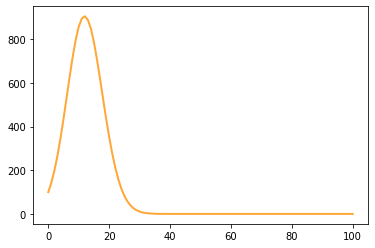

In [12]:
plt.plot(t,T,label='T Cells',color=colors['D'],linewidth=2)
print(np.max(T))

In [13]:
def z_M(M):
    return 1 - np.exp(-M)

def tumor_immune_chemo_forward_integrate_simplified(initial_conditions, params, t):
    """
    Forward integrates the tumor, dendritic, NK T, CD8+ T cell, chemotherapy model
    
    Parameters: 
    ----------
    initial_conditions : (int, int, int, int, int, int)
        Tuple of initial conditions for the IVP
    params : floats
        parameters of the model
    t : [ints]
        an array of timepoints, ASSUMED TO BE EQUALLY SPACED. 
    Returns: 
    -------
    np.array, np.array, np.array
        Returns a numpy array of T, N, D, and M arrays.
    """
    T0, N0, D0, L0, M0, I0 = initial_conditions
    T, N, D, L, M, I = [T0], [N0], [D0], [L0], [M0], [I0]
    a, b, c1, j, k, K_T, s1, g1, h1, c2, d1, K_N, e, s2, f1, d2, d3, K_D, g, f2, h, u, r1, p_I, g_I, i, v_L, d4, V_m, d5, V_i, K_L = params
    dt = t[1] - t[0]

    for _ in t[1:]:
        Tt = T[-1] + (a*T[-1]*(1 - b*T[-1]) - (c1*N[-1] + j*D[-1] + k*L[-1])*T[-1] - K_T*z_M(M[-1])*T[-1])*dt
        Nt = N[-1] + (s1-((c2*T[-1] - d1*D[-1])*N[-1]) - K_N*z_M(M[-1])*N[-1] - e*N[-1])*dt
        Dt = D[-1] + (s2 - (f1*L[-1] + d2*N[-1] - d3*T[-1])*D[-1] - K_D*z_M(M[-1])*D[-1] - g*D[-1])*dt
        Lt = L[-1] + (f2*D[-1]*T[-1] - h*L[-1]*T[-1] - u*N[-1]*(L[-1]**2) - K_L*z_M(M[-1])*L[-1] - i*L[-1] + v_L)*dt
        Mt = M[-1] + (-d4*M[-1] + V_m)*dt
        It = I[-1] + (-d5*I[-1] + V_i)*dt
        
        T.append(Tt)
        N.append(Nt)
        D.append(Dt)
        L.append(Lt)
        M.append(Mt)
        I.append(It)
    return T, N, D, L, M, I

[100, 139.5583124104137, 44.03467300616333, 103018.98829568941, 2520932926924924.5, 9.64409340654968e+39, 1.3156178139676611e+93, 5.55099942641291e+211, -inf, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


/Users/sarthakshukla/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in double_scalars
/Users/sarthakshukla/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in double_scalars
/Users/sarthakshukla/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in double_scalars
/Users/sarthakshukla/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in double_scalars
/Users/sarthakshukla/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
/Users/sarthakshukla/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


Text(0, 0.5, 'Cell Population')

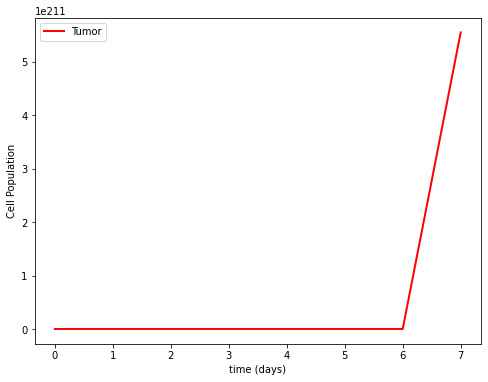

In [14]:
# Effect of drugs on tumor cells computation (Figure 8)

T0 = 100
N0 = 1
D0 = 1
L0 = 1
M0 = 0.5
I0 = 0.5
initial_conditions = (T0, N0, D0, L0, M0, I0)

# a, b, c1, j, k, K_T, s1, g1, h1, c2, d1, K_N, e, s2, f1, d2, d3, K_D, g, f2, h, u, r1, p_I, g_I, i, v_L, d4, V_m, d5, V_i, K_L
a = 4.31e-1 # Tumor growth rate
b = 2.17e-8 # Tumor carrying capacity
c1 = 3.5e-6 # NK cell tumor cell kill rate
j = 1e-7 # dendritic cell tumor cell kill rate
k = 1e-7 # CD8+ T cell tumor cell kill rate
K_T = 9e-2

s1 = 1.3e4 # source of NK cells
g1 = 0
h1 = 0
c2 = 1e-7 # NK cell inactivation rate
d1 = 1e-6 # rate of dendritic cell priming NK cells
K_N = 6e-2
e = 4.12e-2 # death rate of NK cell

s2 = 4.8e2 # source of dendritic cell
f1 = 1e-8 # CD8+ T cell dendritic cells kill rate
d2 = 4e-6 # NK cell dendritic cell kill rate
d3 = 1e-4 # rate of tumor cells priming dendritic cells, originally 1e-4
K_L = 6e-2
g = 2.4e-2 # death rate of dendritic cells

f2 = 0.01 # rate of dendritic cells priming CD8+ T cell
h = 3.42e-10 # T inactivation rate by tumor cells
u = 1.8e-8 # regulatory function by Nk cells of CD8+ T cells, originally 1.8e-8
r1 = 0
p_I = 0
g_I = 0
i = 2e-2 # death rate of CD8+ T cells
v_L = 10e6

d4 = 0
V_m = 1
d5 = 0
V_i = 0
K_D = 6e-2

params = a, b, c1, j, k, K_T, s1, g1, h1, c2, d1, K_N, e, s2, f1, d2, d3, K_D, g, f2, h, u, r1, p_I, g_I, i, v_L, d4, V_m, d5, V_i, K_L

# Timesteps in days
t_max = 100
dt = 1
t = np.linspace(0, t_max, int(t_max/dt) + 1)

results = tumor_immune_chemo_forward_integrate_simplified(initial_conditions, params, t)

# Plot Results
colors = {
'T':'red',
'N':'black',
'D':'#FFA737',
'L': 'blue'
}

# Set up the axes
fig, ax = plt.subplots(figsize=(8,6), nrows=1,ncols=1)
T,N,D,L,M,I = results
print(T)
plt.plot(t,T,label='Tumor',color=colors['T'],linewidth=2)
#plt.plot(t,N,label='NK Cells',color=colors['N'],linewidth=2)
#plt.plot(t,D,label='Dendritic Cells',color=colors['D'],linewidth=2)
#plt.plot(t,L,label='CD8+ T Cells',color=colors['L'],linewidth=2)

# Make the plot attractive
ax.legend(loc='best')
ax.set_xlabel('time (days)')
ax.set_ylabel('Cell Population')

In [15]:
T0 = 40000
E0 = 30000
M0 = 0
initial_conditions = (T0, E0, M0)

p = 0.015
r = 0.47 # Rate of tumor growth
b = 10e-9
a = 3.41e-10
g = 10e5
s = 1.2e4
m = 2e-11
mu = 4.12e-2
gamma = 0.9
h = 2.02e1
K_t = 0.8
K_e = 0.6
V_m = 0.6 # Rate of concentration of chemotherapy
params = p, r, b, a, g, s, m, mu, gamma, h, K_t, K_e, V_m

# Timesteps in days
t_max = 50
dt = 1
t = np.linspace(0, t_max, int(t_max/dt) + 1)

results = tumor_effector_chemo_forward_integrate(initial_conditions, params, t)

# Plot Results
colors = {
'T':'red',
'E':'black',
'M':'#FFA737'}

# Set up the axes
fig, ax = plt.subplots(figsize=(8,6), nrows=1,ncols=1)
T,E,M = results
plt.plot(t,T,label='Tumor',color=colors['T'],linewidth=2)
plt.plot(t,E,label='Effector',color=colors['E'],linewidth=2)
plt.plot(t,M,label='Concentration',color=colors['M'],linewidth=2)

# Make the plot attractive
ax.legend(loc='best')
ax.set_xlim(left=0)
ax.set_xlabel('time (days)')
ax.set_ylabel('Cell Population')

NameError: name 'tumor_effector_chemo_forward_integrate' is not defined

0.5555555555555556


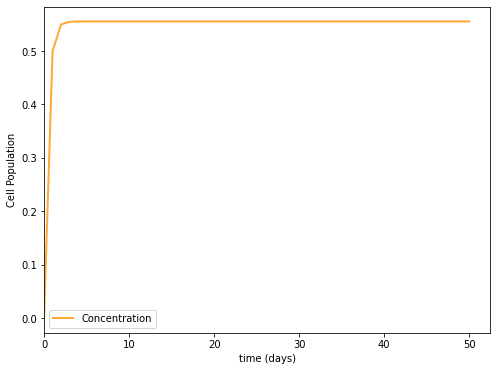

In [16]:
M0 = 0.0
initial_conditions = (M0)

gamma = 0.9
V_m = 0.5 # Rate of concentration of chemotherapy

params = gamma, V_m

# Timesteps in days
t_max = 50
dt = 1
t = np.linspace(0, t_max, int(t_max/dt) + 1)

results = chemo_forward_integrate(initial_conditions, params, t)

# Plot Results
colors = {
'M':'#FFA737'}

# Set up the axes
fig, ax = plt.subplots(figsize=(8,6), nrows=1,ncols=1)
M = results
plt.plot(t,M,label='Concentration',color=colors['M'],linewidth=2)

# Make the plot attractive
ax.legend(loc='best')
ax.set_xlim(left=0)
ax.set_xlabel('time (days)')
ax.set_ylabel('Cell Population')
print(np.max(M))

In [17]:
def plot_results(results, t, param):
    # Plot Results
    colors = {
    'T':'red',
    'E':'black',
    'M':'#FFA737'}

    # Set up the axes
    fig, ax = plt.subplots(nrows=1,ncols=1)
    T,E,M = results
    plt.plot(t,T,label='T',color=colors['T'],linewidth=2)
    plt.plot(t,E,label='E',color=colors['E'],linewidth=2)
    plt.plot(t,M,label='M',color=colors['M'],linewidth=2)
    plt.title(f'{param[0]} = {param[1]}') # add title to identify which parameter is being changed and what value it has

    # Make the plot attractive
    ax.legend(loc='best')
    ax.set_xlim(left=0)
    ax.set_ylim([0, 250000])
    ax.set_xlabel('time (days)')
    ax.set_ylabel('Cell Population')
    
    plt.show()

In [18]:
def create_param_ls(x):
    # takes a parameter and creates a list of 20 values between double and half the original
    return np.linspace(x/2, x*2, 20)

In [19]:
def initialize():
    # innitializes parameters to default values for first paper plot, used for parameter sweeps
    T0 = 40000
    E0 = 30000
    M0 = 0
    initial_conditions = (T0, E0, M0)

    p = 0.015
    r = 4.31e-3 # Rate of tumor growth
    b = 10e-9
    a = 3.41e-10
    g = 10e5
    s = 1.2e4
    m = 2e-11
    mu = 4.12e-2
    gamma = 0.9
    h = 2.02e1
    K_t = 0.7
    K_e = 0.6
    V_m = 0.5 # Rate of concentration of chemotherapy 
    params = p, r, b, a, g, s, m, mu, gamma, h, K_t, K_e, V_m
    param_dic = {"p":p, "r":r, "b":b, "a":a, "g":g, "s":s, "m":m, "mu":mu, "gamma":gamma, "h":h, "K_t":K_t, "K_e":K_e, "V_m":V_m}


    # Timesteps in days
    t_max = 50
    dt = 1
    t = np.linspace(0, t_max, int(t_max/dt) + 1)
    
    return initial_conditions, params, t, param_dic

In [20]:
def sweep(param):
    initial_conditions, params, t, param_dic = initialize()
    ls = ["K_t", "K_e", "V_m", "gamma"]
    if param in ls:
        # i think it is best to keep values below 1, but if they are too far away, keep them within their bounds if that makes sense, so only 
        # these four will be simple 0 - 1 arange
        values = np.arange(0, 1.1, 0.1)
    else:
        values = create_param_ls(param_dic[param])
    for value in values:
        param_dic[param] = value
        params_new = tuple(param_dic.values())
        results = tumor_effector_chemo_forward_integrate(initial_conditions, params_new, t)
        plot_results(results, t,[param, value])
        

In [21]:
# Parameter sweep code for unknown vars and some potential other key ones
# starting off with K_t which determines the rate at which tumor cells are killed by chemo

sweep("K_t")

    




NameError: name 'tumor_effector_chemo_forward_integrate' is not defined

Equilibrium and Stability Analysis

The paper proposes calculating equilibrium with the absence of treatment so they eliminate the chemotherapy and immunotherapy equations from the system of ODEs.

Let $E(T^*, N^*, D^*, L^*)$ be an equilibrium point of the system described by the system without drug intervention to represent tumor free equilibriums.

Because constant recruitment through source terms  $s_1$ and $s_2$ is assumed to be constant and not equal to zero, there is no trivial equilibrium which implies: $E(T^*, N^*, D^*, L^*) \neq (0,0,0,0) $

This leaves us two equilibrium solutions: $E_1(0, N^*, D_{1}^*, 0)$ AND  $E_2(0, N^*, D_{2}^*, 0)$

For tumor free equilibriums we set $dN/dt = 0$ which yields $N^* = \frac{s_1}{e-d_1 D^*}$

Similarly, setting $dD/dt = 0$ yields $D_{1,2}^* = \frac{d_1 s_2 + d_2 s_1 + eg \pm \sqrt{(d_1 s_2 + d_2 s_1)^2 - 4 g e s_2}}{2 g d_1}$

In order for the tumor-free equilibrium to be stable it is required that $\lambda_1 < 0$, the first eigenvalue of the jacobian matrix for linearization of system without drug intervention. 
This implies that if the tumor growth rate $a$ is lesser than the critical value given by $c_1 N^* + J D^*$, then the tumor population can be eliminated.

$\lambda_1 = a - c_1 N^* + J D^*$


In [25]:

j = 1e-7    # dendritic cell tumor cell kill rate
c1 = 3.5e-6 # NK cell tumor cell kill rate
a = 4.31e-1 # Tumor growth rate
d1 = 1e-6   # rate of dendritic cell priming NK cells
d2 = 4e-6   # NK cell dendritic cell kill rate
s1 = 1.3e4  # source of NK cells
s2 = 4.8e2  # source of dendritic cell
e = 4.12e-2 # death rate of NK cell
g = 2.4e-2  # death rate of dendritic cells


# print((d1*s2 + d2*s1 + e*g) >= 2*np.sqrt(g*e*s2))
# print('before minus sign in square root', (d1*s2 + d2*s1 + e*g)**2)
# print('after minus sign in square root', 4*g*e*s2)
# print('before square rooting value', ((d1*s2 + d2*s1 + e*g)**2) - (4*g*e*s2))
T_star = 0.0
L_star = 0.0
D_star1 = (((d1*s2) + (d2*s1) + (e*g)) + np.sqrt((((d1*s2 )+ (d2*s1) + (e*g))**2) - (4*g*e*s2)))/(2*g*d1)
N_star1 = s1/(e-(d1*D_star1))
D_star2 = ((d1*s2 + d2*s1 + e*g) - np.sqrt(((d1*s2 + d2*s1 + e*g)**2) - 4*g*e*s2))/(2*g*d1)
N_star2 = s1/(e-(d1*D_star2))
E1 = [T_star, N_star1, D_star1, L_star]
E2 = [T_star, N_star2, D_star2, L_star]


E1_stable = 'unstable'
E2_stable = 'unstable'
E1_stable_comp = a - (c1*N_star1) - (j*D_star1)
E2_stable_comp = a - (c1*N_star2) - (j*D_star2)
if(E1_stable_comp < 0.0):
    E1_stable = 'stable'
if(E2_stable_comp < 0.0):
    E2_stable = 'stable'

print('Equilibrium point one: (T* = %s, N *= %s, D* = %s, L* = %s,)' % (E1[0], E1[1], E1[2], E1[3]))
print('Equilibrium point 1 stability analysis: ', E1_stable)
print('Equilibrium point two: (T* = %s, N *= %s, D* = %s, L* = %s,)' % (E2[0], E2[1], E2[2], E2[3]))
print('Equilibrium point 2 stability analysis: ', E2_stable)



False
before minus sign in square root 0.00285891257344
after minus sign in square root 1.898496
before square rooting value -1.89563708742656
Equilibrium point one: (T* = 0.0, N *= nan, D* = nan, L* = 0.0,)
Equilibrium point 1 stability analysis:  unstable
Equilibrium point two: (T* = 0.0, N *= nan, D* = nan, L* = 0.0,)
Equilibrium point 2 stability analysis:  unstable


/var/folders/kr/m6vn45tx0p33n65v1q9plv6w0000gn/T/ipykernel_71845/615477184.py:18: RuntimeWarning: invalid value encountered in sqrt
  D_star1 = (((d1*s2) + (d2*s1) + (e*g)) + np.sqrt((((d1*s2 )+ (d2*s1) + (e*g))**2) - (4*g*e*s2)))/(2*g*d1)
/var/folders/kr/m6vn45tx0p33n65v1q9plv6w0000gn/T/ipykernel_71845/615477184.py:20: RuntimeWarning: invalid value encountered in sqrt
  D_star2 = ((d1*s2 + d2*s1 + e*g) - np.sqrt(((d1*s2 + d2*s1 + e*g)**2) - 4*g*e*s2))/(2*g*d1)
